In [212]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from category_encoders import BinaryEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, SelectPercentile

from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

from sklearn.model_selection import GridSearchCV

## **Exercise: Model Evaluation Cross Validation**

**Gunakan dataset 'titanic.csv'**

**Target: 'alive'**

- Skema pre-processing:
  * Drop feature 'deck'
  * Isi missing value 'age' dengan simple imputer median
  * Isi missing value 'embark town' dengan simple imputer modus
  * One hot encoding: 'sex', 'embark town', 'alone' 
  * Ordinal encoding: 'class'
  * Scaling dengan RobustScaler()
<br><br>
- Split data menjadi 80:20 dengan random_state = 0.
- Tentukan metric evaluasi yang sesuai untuk kasus Titanic.
- Pilih model terbaik dengan cross-validation (n_splits=5):
    * Logistic regression: solver = liblinear
    * KNN: n_neighbors = 3
    * Decision tree: max depth = 3
<br>
- Predict model ke test set

In [213]:
df = sns.load_dataset('titanic')
df.drop(columns='deck', inplace=True)
pd.set_option('display.max_columns', None)
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,Southampton,no,True


In [214]:
df['survived'].value_counts()

survived
0    549
1    342
Name: count, dtype: int64

In [215]:
df['alive'].value_counts()

alive
no     549
yes    342
Name: count, dtype: int64

In [216]:
df['pclass'].value_counts()

pclass
3    491
1    216
2    184
Name: count, dtype: int64

In [217]:
df['class'].value_counts()

class
Third     491
First     216
Second    184
Name: count, dtype: int64

In [218]:
df['sex'].value_counts()

sex
male      577
female    314
Name: count, dtype: int64

In [219]:
df['who'].value_counts()

who
man      537
woman    271
child     83
Name: count, dtype: int64

In [220]:
df['adult_male'].value_counts()

adult_male
True     537
False    354
Name: count, dtype: int64

In [221]:
df['embarked'].value_counts()

embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [222]:
df['embark_town'].value_counts()

embark_town
Southampton    644
Cherbourg      168
Queenstown      77
Name: count, dtype: int64

In [223]:
df.drop(columns=['survived','pclass','embarked'], inplace=True)

In [224]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   sex          891 non-null    object  
 1   age          714 non-null    float64 
 2   sibsp        891 non-null    int64   
 3   parch        891 non-null    int64   
 4   fare         891 non-null    float64 
 5   class        891 non-null    category
 6   who          891 non-null    object  
 7   adult_male   891 non-null    bool    
 8   embark_town  889 non-null    object  
 9   alive        891 non-null    object  
 10  alone        891 non-null    bool    
dtypes: bool(2), category(1), float64(2), int64(2), object(4)
memory usage: 58.6+ KB


In [225]:
value_counts_dict = {}

for col in df.columns:
    if df[col].dtype == 'object' or df[col].dtype == 'category':
        value_counts_dict[col] = df[col].value_counts()

for col, value_counts in value_counts_dict.items():
    print(f"Value counts for column '{col}':\n{value_counts}\n")

Value counts for column 'sex':
sex
male      577
female    314
Name: count, dtype: int64

Value counts for column 'class':
class
Third     491
First     216
Second    184
Name: count, dtype: int64

Value counts for column 'who':
who
man      537
woman    271
child     83
Name: count, dtype: int64

Value counts for column 'embark_town':
embark_town
Southampton    644
Cherbourg      168
Queenstown      77
Name: count, dtype: int64

Value counts for column 'alive':
alive
no     549
yes    342
Name: count, dtype: int64



In [226]:
value_counts_dict2 = {}

for col in df.columns:
    if df[col].dtype == 'bool':
        value_counts_dict2[col] = df[col].value_counts()

for col, value_counts in value_counts_dict2.items():
    print(f"Value counts for column '{col}':\n{value_counts}\n")

Value counts for column 'adult_male':
adult_male
True     537
False    354
Name: count, dtype: int64

Value counts for column 'alone':
alone
True     537
False    354
Name: count, dtype: int64



In [227]:
# df.replace('?',np.nan, inplace= True)

In [228]:
df.duplicated().sum()

111

In [229]:
df.drop_duplicates(inplace= True)

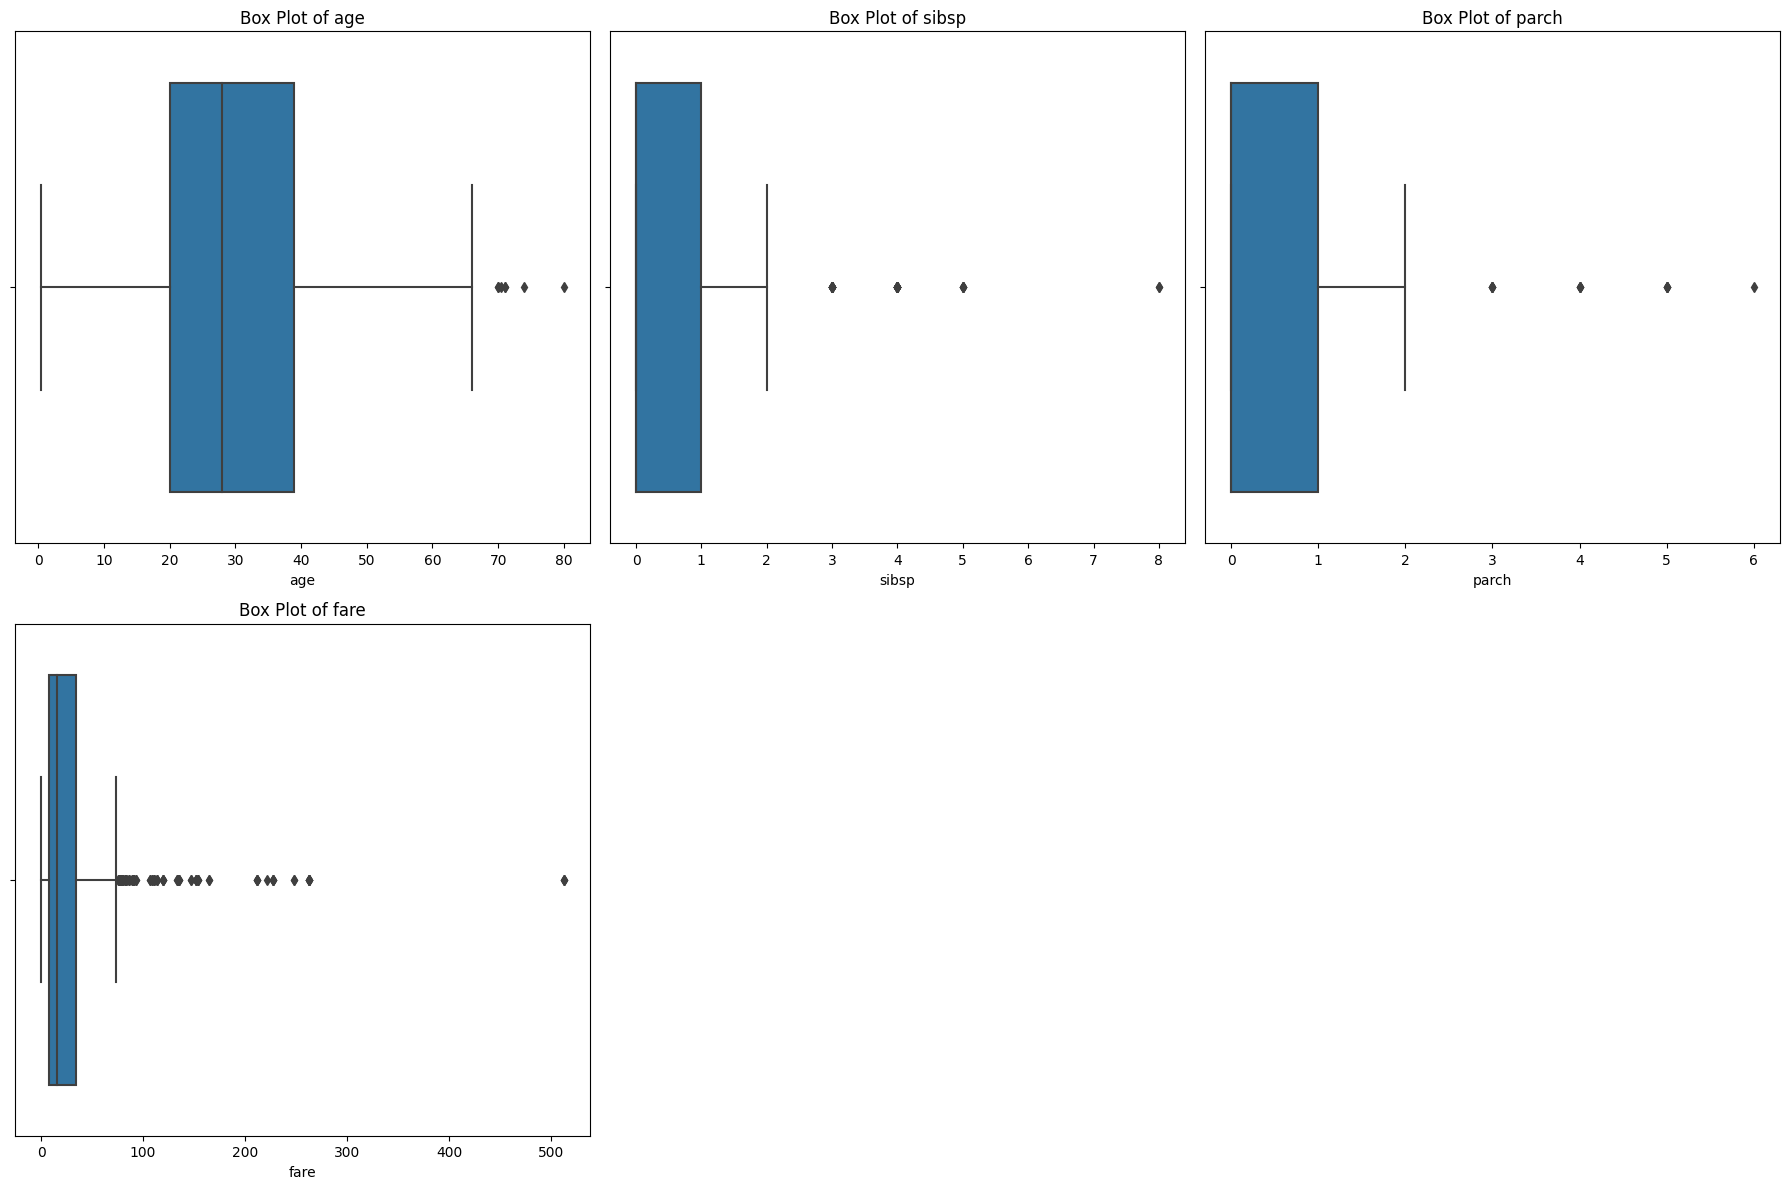

In [230]:
def numerical_boxplots(data):
    numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns
    num_plots = len(numerical_columns)
    num_rows = (num_plots + 2) // 3

    fig, axes = plt.subplots(num_rows, 3, figsize=(18, 6 * num_rows))
    axes = axes.ravel()  # Flatten the 2D array of axes

    for i, column in enumerate(numerical_columns):
        sns.boxplot(data=data, x=column, ax=axes[i])
        axes[i].set_title(f'Box Plot of {column}')
        # axes[i].set_ylabel(column)

    # Hide any empty subplots
    for i in range(num_plots, num_rows * 3):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


numerical_boxplots(df)

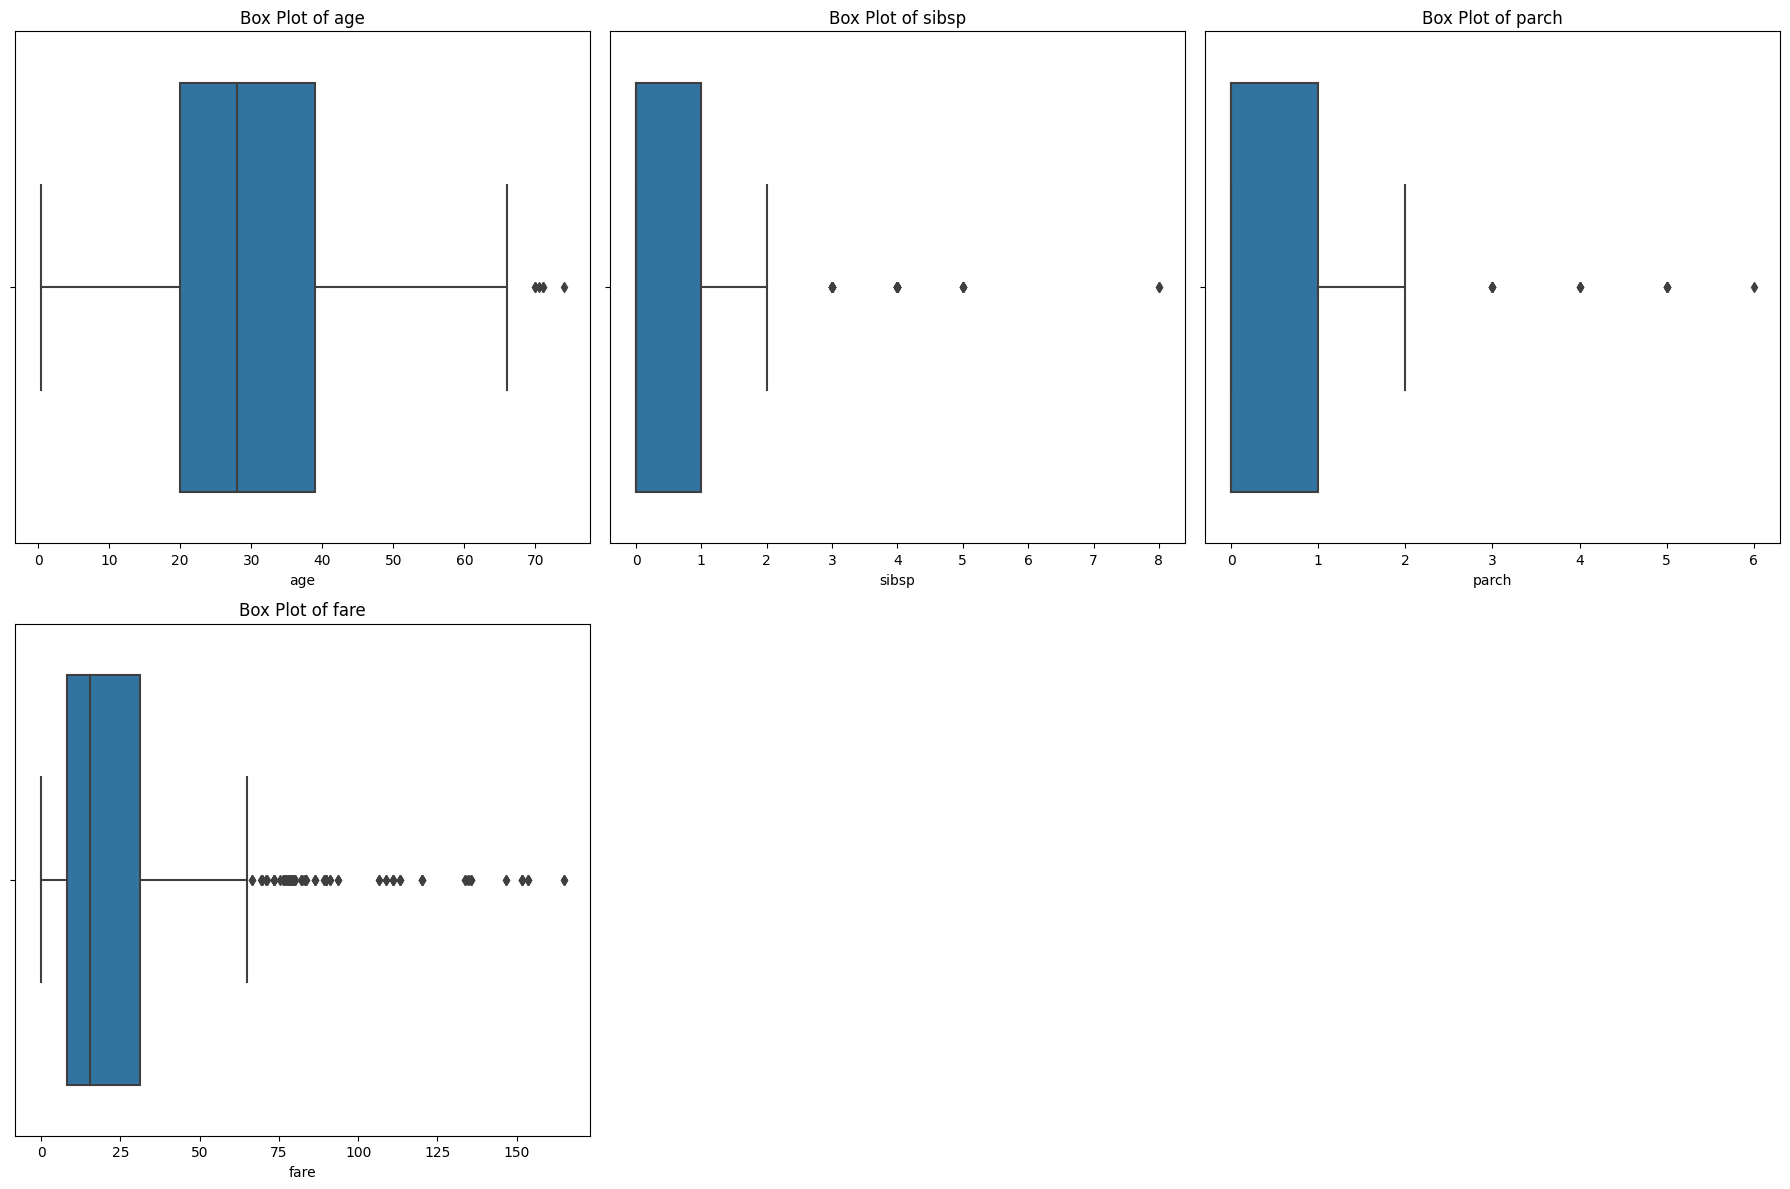

In [231]:
df = df[~((df['age']>75) | (df['fare']>200))]
# df = df[~((df['age']>75) | (df['fare']>200))]
numerical_boxplots(df)

# EDA

In [232]:
df['alive'].value_counts()

alive
no     452
yes    307
Name: count, dtype: int64

In [233]:
df['alive'] = np.where(df['alive']=='yes',1,0).astype('int64')

In [234]:
Y = df['alive']
X = df.drop(columns=['alive'])
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=0, stratify= Y)

In [235]:
df.isna().sum()[df.isna().sum()>0]

age            102
embark_town      2
dtype: int64

In [236]:
df.select_dtypes(include=['int64', 'float64']).columns

Index(['age', 'sibsp', 'parch', 'fare', 'alive'], dtype='object')

In [237]:
df.select_dtypes(include=['object','category']).columns

Index(['sex', 'class', 'who', 'embark_town'], dtype='object')

In [238]:
df.select_dtypes(include=['bool']).columns

Index(['adult_male', 'alone'], dtype='object')

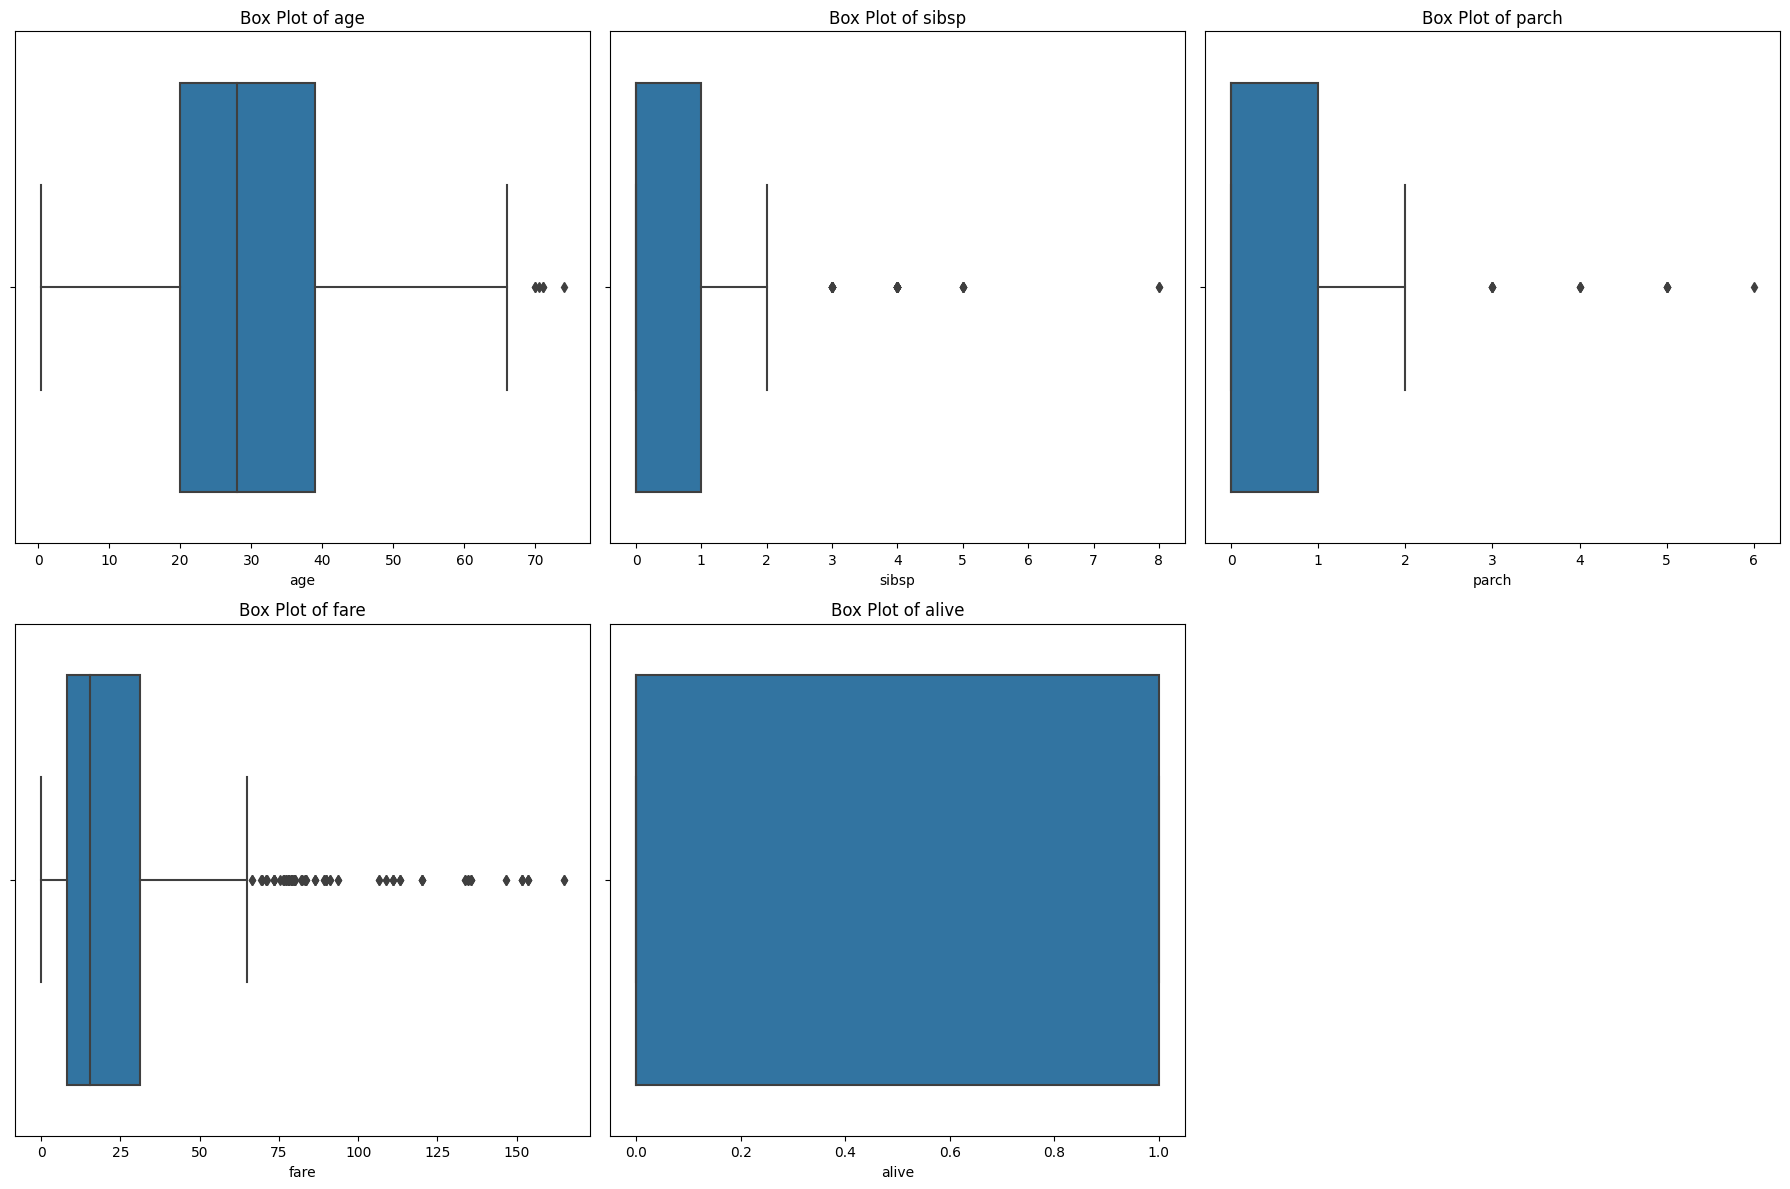

In [239]:
numerical_boxplots(df)

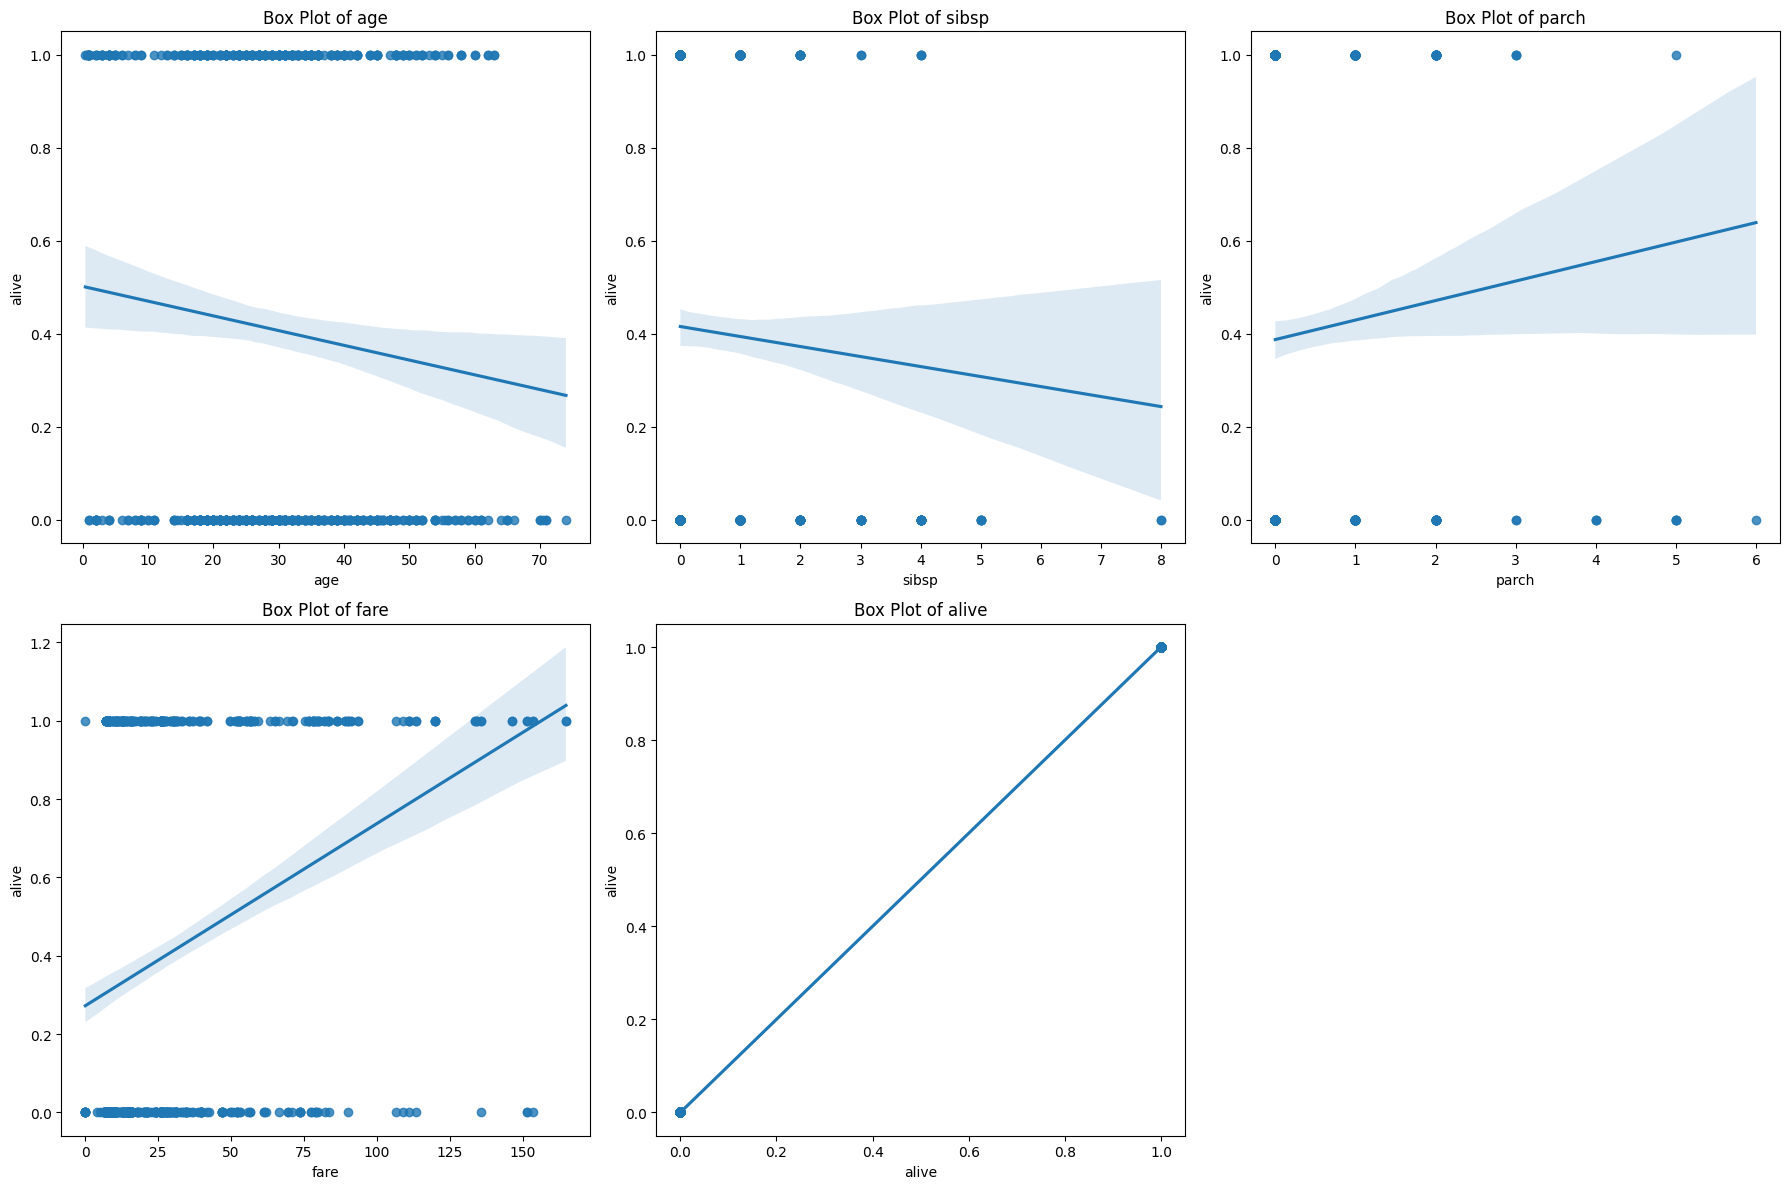

In [240]:
def numerical_regplot(data, y_axis):
    numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns
    num_plots = len(numerical_columns)
    num_rows = (num_plots + 2) // 3

    fig, axes = plt.subplots(num_rows, 3, figsize=(18, 6 * num_rows))
    axes = axes.ravel()  # Flatten the 2D array of axes

    for i, column in enumerate(numerical_columns):
        sns.regplot(data=data, x=column, y=y_axis, ax=axes[i])
        axes[i].set_title(f'Box Plot of {column}')
        # axes[i].set_ylabel(column)

    # Hide any empty subplots
    for i in range(num_plots, num_rows * 3):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

numerical_regplot(df, 'alive')

In [241]:
df['class'].value_counts()

class
Third     404
First     191
Second    164
Name: count, dtype: int64

In [242]:
pipe_iter_robust = Pipeline([('iter_imp',IterativeImputer()), ('robust', RobustScaler())])
# pipe_iter_bin_one = Pipeline([('iter_imp',IterativeImputer()), ('bin_one', KBinsDiscretizer(strategy='uniform', n_bins= 5, encode='onehot'))])
# pipe_iter_bin_or = Pipeline([('iter_imp',IterativeImputer()), ('bin_one', KBinsDiscretizer(strategy='uniform', n_bins= 5, encode='ordinal'))])
# pipe_knn_robust = Pipeline([('knn_imp',KNNImputer(n_neighbors=5)), ('robust', RobustScaler())])
# pipe_knn_bin_one = Pipeline([('knn_imp',KNNImputer(n_neighbors=5)), ('bin_one', KBinsDiscretizer(strategy='uniform', n_bins= 5, encode='onehot'))])
# pipe_knn_bin_or = Pipeline([('knn_imp',KNNImputer(n_neighbors=5)), ('bin_one', KBinsDiscretizer(strategy='uniform', n_bins= 5, encode='ordinal'))])


pipe_mode_onehot = Pipeline([('mode',SimpleImputer(strategy='most_frequent')), ('onehot',OneHotEncoder())])
pipe_mode_ordinal = Pipeline([('mode', SimpleImputer(strategy='most_frequent')),
                              ('ordinal', OrdinalEncoder(categories=[['Third', 'Second', 'First']], dtype=int))])
# pipe_mode_binary = Pipeline([('mode',SimpleImputer(strategy='most_frequent')), ('binary',BinaryEncoder())])



pipe_median_robust = Pipeline([('median',SimpleImputer(strategy='median')), ('robust', RobustScaler())])

transformer = ColumnTransformer([
    ('pipe_median_robust',pipe_median_robust,['age']),
    ('pipe_iter_robust',pipe_iter_robust,['sibsp', 'parch', 'fare']),
    # ('pipe_iter_bin_one',pipe_iter_bin_one,['']),
    # ('pipe_iter_bin_or',pipe_iter_bin_or,['']),
    # ('pipe_knn_robust',pipe_knn_robust,['']),
    # ('pipe_knn_bin_one',pipe_knn_bin_one,['']),
    # ('pipe_knn_bin_or',pipe_knn_bin_or,['']),
    ('pipe_mode_onehot',pipe_mode_onehot,['sex', 'embark_town', 'alone', 'who','adult_male']),
    ('pipe_mode_ordinal',pipe_mode_ordinal,['class']),
    # ('pipe_mode_binary',pipe_mode_binary,[''])
    ], remainder='passthrough')
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipe_median_robust',
                                 Pipeline(steps=[('median',
                                                  SimpleImputer(strategy='median')),
                                                 ('robust', RobustScaler())]),
                                 ['age']),
                                ('pipe_iter_robust',
                                 Pipeline(steps=[('iter_imp',
                                                  IterativeImputer()),
                                                 ('robust', RobustScaler())]),
                                 ['sibsp', 'parch', 'fare']),
                                ('pipe_mode_onehot',
                                 Pipeline(steps=[('mode',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot', OneHotEncoder())]),
                                 ['sex', 'embark_town', 'alone', 'who',
                                  'adult_male']),
                                ('pipe_mode_ordinal',
                                 Pipeline(steps=[('mode',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['Third',
                                                                              'Second',
                                                                              'First']],
                                                                 dtype=<class 'int'>))]),
                                 ['class'])])

# Cross Valiadtion

In [243]:
cross_val_df = pd.DataFrame(columns=['Model','Mean Score','Std Score','Acc All'])

for model in [LogisticRegression(random_state=0, solver='liblinear'), KNeighborsClassifier(n_neighbors=3), DecisionTreeClassifier(random_state=0, max_depth=3)]:

    pipe_model = Pipeline([
        ('preprocessing', transformer),
        ('modeling', model)
        ])

    val_scores = cross_val_score(estimator=pipe_model, X= X_train, y=Y_train,
                                #  scoring='neg_mean_squared_error',
                                 scoring='accuracy',
                                 cv= 5)        # cv= 5 --> Automate between KFold and StratifiedKFold
    cross_val_df.loc[len(cross_val_df)] = {
        'Model':model,
        'Mean Score': val_scores.mean(),
        'Std Score': val_scores.std(),
        'Acc All':np.round(val_scores, 2)}
    
cross_val_df

,Model,Mean Score,Std Score,Acc All
0,"LogisticRegression(random_state=0, solver='lib...",0.798997,0.013611,"[0.8, 0.8, 0.82, 0.79, 0.78]"
1,KNeighborsClassifier(n_neighbors=3),0.777578,0.020406,"[0.78, 0.79, 0.76, 0.81, 0.75]"
2,"DecisionTreeClassifier(max_depth=3, random_sta...",0.797331,0.022691,"[0.84, 0.78, 0.81, 0.79, 0.78]"


# Hyperparameter Tuning

In [244]:
# model = Lasso()
# param = {'modeling__alpha':np.logspace(4,-4,9)}
# model = Ridge()
# param = {'modeling__alpha':np.logspace(4,-4,9)}

model = LogisticRegression(random_state=0, solver='liblinear')
param = {'modeling__C':np.logspace(4,-4,9)}
# model = KNeighborsClassifier()
# param = {'modeling__n_neighbors':list(range(1,len(X_train),2))}
# model = DecisionTreeClassifier(random_state=0)
# param = {'modeling__max_depth':list(range(20))}

pipe_model = Pipeline([
    ('preprocessing', transformer),
    ('modeling', model)
    ])

GridSearch = GridSearchCV(estimator=pipe_model, param_grid=param, cv=5, n_jobs=-1,
                          #  scoring='neg_mean_squared_error',
                          scoring='accuracy'
                          )

GridSearch.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('pipe_median_robust',
                                                                         Pipeline(steps=[('median',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('robust',
                                                                                          RobustScaler())]),
                                                                         ['age']),
                                                                        ('pipe_iter_robust',
                                                                         Pipeline(steps=[('iter_imp',
                                                                                          IterativeImputer()),
                                                                                         ('robust',
                                                                                          RobustScaler())]),
                                                                         ['sibsp',
                                                                          'parch',
                                                                          '...
                                                                         Pipeline(steps=[('mode',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ordinal',
                                                                                          OrdinalEncoder(categories=[['Third',
                                                                                                                      'Second',
                                                                                                                      'First']],
                                                                                                         dtype=<class 'int'>))]),
                                                                         ['class'])])),
                                       ('modeling',
                                        LogisticRegression(random_state=0,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'modeling__C': array([1.e+04, 1.e+03, 1.e+02, 1.e+01, 1.e+00, 1.e-01, 1.e-02, 1.e-03,
       1.e-04])},
             scoring='accuracy')

In [245]:
pd.DataFrame(GridSearch.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_modeling__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.056135,0.007512,0.017668,0.005142,10000.0,{'modeling__C': 10000.0},0.811475,0.803279,0.818182,0.793388,0.785124,0.802290,0.011932,1
1,0.062091,0.016564,0.016242,0.002201,1000.0,{'modeling__C': 1000.0},0.811475,0.803279,0.818182,0.793388,0.785124,0.802290,0.011932,1
2,0.053155,0.003103,0.018643,0.001654,100.0,{'modeling__C': 100.0},0.811475,0.803279,0.818182,0.793388,0.785124,0.802290,0.011932,1
3,0.056712,0.007396,0.017734,0.000969,10.0,{'modeling__C': 10.0},0.811475,0.803279,0.818182,0.793388,0.785124,0.802290,0.011932,1
4,0.063495,0.010755,0.018015,0.001929,1.0,{'modeling__C': 1.0},0.803279,0.803279,0.818182,0.793388,0.776860,0.798997,0.013611,5
5,0.054162,0.005365,0.019062,0.002023,0.1,{'modeling__C': 0.1},0.803279,0.786885,0.793388,0.793388,0.785124,0.792413,0.006382,6
6,0.056741,0.007285,0.017591,0.001602,0.01,{'modeling__C': 0.01},0.811475,0.762295,0.801653,0.785124,0.768595,0.785828,0.018759,7
7,0.048957,0.004109,0.016274,0.003054,0.001,{'modeling__C': 0.001},0.786885,0.803279,0.785124,0.752066,0.760331,0.777537,0.018721,8
8,0.050503,0.002870,0.015259,0.001482,0.0001,{'modeling__C': 0.0001},0.770492,0.762295,0.776860,0.727273,0.727273,0.752838,0.021379,9


In [246]:
GridSearch.best_params_

{'modeling__C': 10000.0}

In [247]:
GridSearch.best_score_

0.8022896626473377

In [248]:
GridSearch.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipe_median_robust',
                                                  Pipeline(steps=[('median',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('robust',
                                                                   RobustScaler())]),
                                                  ['age']),
                                                 ('pipe_iter_robust',
                                                  Pipeline(steps=[('iter_imp',
                                                                   IterativeImputer()),
                                                                  ('robust',
                                                                   RobustScaler())]),
                                                  ['sibsp', 'parch', 'fare']),
                                                 ('pipe_mode_onehot',...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder())]),
                                                  ['sex', 'embark_town',
                                                   'alone', 'who',
                                                   'adult_male']),
                                                 ('pipe_mode_ordinal',
                                                  Pipeline(steps=[('mode',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(categories=[['Third',
                                                                                               'Second',
                                                                                               'First']],
                                                                                  dtype=<class 'int'>))]),
                                                  ['class'])])),
                ('modeling',
                 LogisticRegression(C=10000.0, random_state=0,
                                    solver='liblinear'))])

# Predict to Target

In [249]:
df_acc = pd.DataFrame(columns=['Train Accuracy','Test Accuracy'])

# model = Lasso(alpha=param_tuning)
# model = Ridge(alpha=param_tuning)
model = LogisticRegression(random_state=10, solver='liblinear', C=10000)
# model = KNeighborsClassifier(n_neighbors=param_tuning)
# model = DecisionTreeClassifier(random_state=10, max_depth=param_tuning)
        
pipe_model = Pipeline([('preprocessing', transformer), ('modeling', model)])
pipe_model.fit(X_train, Y_train)
Y_train_predict = pipe_model.predict(X_train)
Y_test_predict = pipe_model.predict(X_test)
df_acc.loc[len(df_acc)] = {'Train Accuracy': accuracy_score(Y_train, Y_train_predict), 'Test Accuracy': accuracy_score(Y_test, Y_test_predict)}

df_acc

,Train Accuracy,Test Accuracy
0,0.802306,0.828947


# Polynomial Feature

c:\Users\Vincent\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Vincent\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Vincent\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Vincent\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


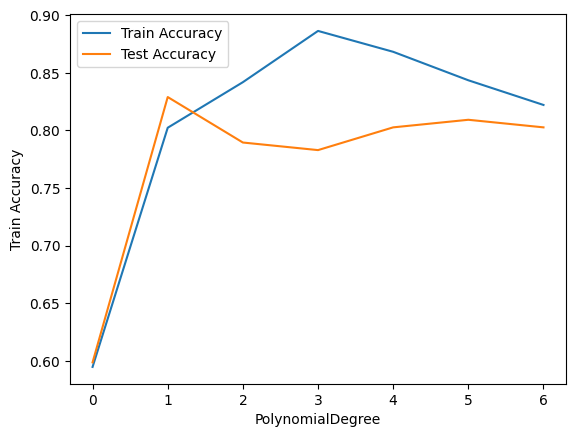

In [251]:
polynomial_feature = 'PolynomialDegree'
df_acc = pd.DataFrame(columns=[polynomial_feature,'Train Accuracy','Test Accuracy'])

for polynomial_degree in range(7):
    polyfeature = PolynomialFeatures(degree=polynomial_degree)
    
    # model = Lasso(alpha=param_tuning)
    # model = Ridge(alpha=param_tuning)
    model = LogisticRegression(random_state=10, solver='liblinear', C=10000)
    # model = KNeighborsClassifier(n_neighbors=param_tuning)
    # model = DecisionTreeClassifier(random_state=10, max_depth=param_tuning)
        
    pipe_model = Pipeline([
        ('preprocessing', transformer),
        ('polyfeature', polyfeature),
        ('modeling', model)
        ])
    pipe_model.fit(X_train, Y_train)
    Y_train_predict = pipe_model.predict(X_train)
    Y_test_predict = pipe_model.predict(X_test)
    df_acc.loc[len(df_acc)] = {
        polynomial_feature: polynomial_degree,
        'Train Accuracy': accuracy_score(Y_train, Y_train_predict),
        'Test Accuracy': accuracy_score(Y_test, Y_test_predict)}

sns.lineplot(data=df_acc, x=polynomial_feature, y='Train Accuracy', label='Train Accuracy')
sns.lineplot(data=df_acc, x=polynomial_feature, y='Test Accuracy', label='Test Accuracy')
plt.show()

In [252]:
print(df_acc[df_acc['Test Accuracy']==df_acc['Test Accuracy'].max()])

   PolynomialDegree  Train Accuracy  Test Accuracy
1                 1        0.802306       0.828947


# Feature Selection

In [253]:
# all_features=[]
# for n_transform in range(4):
#     all_features += list(transformer.transformers_[n_transform][1].get_feature_names_out())

In [254]:
# def feature_selection(n_features):
#     important_features = pd.DataFrame({
#                                         'importance':model.coef_.flatten(),
#                                         # 'importance':model.feature_importances_,
#                                         'features':all_features
#                                     }).sort_values(by='importance', ascending=False).head(n_features)
#     important_features.reset_index(drop=True, inplace=True)
#     important_features.index += 1
#     return important_features

# max_feature = len(all_features)
# feature_df = feature_selection(max_feature)
# feature_df

In [255]:
# df_acc = pd.DataFrame(columns=['N Features','Train Accuracy','Test Accuracy'])


# for n_features in range(1,len(all_features)+1):
#     feature_df = feature_selection(n_features)

#     columns_to_drop = [col for col in X_train.columns if col not in list(feature_df['features'])]
#     X_train_select =X_train.drop(columns=columns_to_drop)
#     X_test_select =X_test.drop(columns=columns_to_drop)

#     transformer_select = ColumnTransformer([
#         ('pipe_iter_robust',pipe_iter_robust,(X_train_select.columns))
#         ], remainder='passthrough')

#     transformer_select.fit(X_train_select)
#     X_train_select = transformer_select.transform(X_train_select)
#     X_test_select = transformer_select.transform(X_test_select)

#     model_select = LogisticRegression(random_state=10, C=10000)
#     model_select.fit(X_train_select, Y_train)
#     Y_train_predict = model_select.predict(X_train_select)
#     Y_test_predict = model_select.predict(X_test_select)
#     df_acc.loc[len(df_acc)] = {
#         'N Features': n_features,
#         'Train Accuracy': accuracy_score(Y_train, Y_train_predict),
#         'Test Accuracy': accuracy_score(Y_test, Y_test_predict)}


# print(df_acc[df_acc['Test Accuracy']==df_acc['Test Accuracy'].max()])
# sns.lineplot(data=df_acc, x='N Features', y='Train Accuracy', label='Train Accuracy')
# sns.lineplot(data=df_acc, x='N Features', y='Test Accuracy', label='Test Accuracy')
# plt.show()